In [ ]:
import copy
import importlib
import os
from itertools import product

import torch
from dotenv import load_dotenv
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner

load_dotenv("../env")

False

In [ ]:
import luminar.mongo

importlib.reload(luminar.mongo)

from luminar.mongo import MongoDatset

domains = [
    "blog_authorship_corpus",
    "student_essays",
    "cnn_news",
    "bundestag",
    "spiegel_articles",
    "euro_court_cases",
    "house_of_commons",
    "arxiv_papers",
    "gutenberg",
]

datasets = {
    domain: MongoDatset(
        mongo_db_connection=os.environ.get("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_prismai",
        domain=domain,
        # lang={"$exists": True},
    )
    for domain in domains
}

In [ ]:
import luminar.document.model

importlib.reload(luminar.document.model)

import luminar.document.data
import luminar.features
from luminar.document.model import ConvolutionalLayerSpec

importlib.reload(luminar.features)
importlib.reload(luminar.document.data)

from luminar.document.data import FeatureDataset, n_way_split
from luminar.features import FeatureExtractor, OneDimFeatures, Slicer, TwoDimFeatures

In [ ]:
# feature_dim = OneDimFeatures(256)
# featurizer = FeatureExtractor.Likelihood()
# featurizer = FeatureExtractor.LogLikelihoodLogRankRatio()
feature_dim = TwoDimFeatures(256, 4)
second_dim_as_channels = True
featurizer = FeatureExtractor.IntermediateLogits(4)

slicer = Slicer.RandomMultiple(feature_dim[0], 8)


def featurize(dataset) -> FeatureDataset:
    return FeatureDataset(dataset, slicer, featurizer)


config = {
    "seed": 42,
    "projection_dim": None,
    "conv_layer_shapes": [  # SeqXGPT Layer Configuration
        ConvolutionalLayerSpec(64, 5),
        ConvolutionalLayerSpec(128, 3),
        ConvolutionalLayerSpec(128, 3),
        ConvolutionalLayerSpec(128, 3),
        ConvolutionalLayerSpec(64, 3),
    ],
    "learning_rate": 0.0001,
    "warmup_steps": 66,
    "second_dim_as_channels": second_dim_as_channels,
    "max_epochs": 20,
    "gradient_clip_val": 0.5,
    "feature_dim": feature_dim,
    "slicer": repr(slicer),
    "featurizer": repr(featurizer),
    "batch_size": 32,
    "eval_split": 0.1,
    "test_split": 0.1,
}

In [84]:
train_datasets, train_splits = {}, {}
eval_datasets, eval_splits = {}, {}
test_datasets, test_splits = {}, {}
for domain, dataset in datasets.items():
    seed_everything(config["seed"])
    train_dataset, eval_dataset, test_dataset = n_way_split(
        dataset, config["eval_split"], config["test_split"], infer_first=True
    )
    train_splits[domain] = train_dataset
    eval_splits[domain] = eval_dataset
    test_splits[domain] = test_dataset
    train_datasets[domain] = featurize(train_dataset)
    eval_datasets[domain] = featurize(eval_dataset)
    test_datasets[domain] = featurize(test_dataset)

Seed set to 42


Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42


## In-Domain Training & Evaluation

In [85]:
import luminar.document.data
import luminar.document.model

importlib.reload(luminar.document.model)
importlib.reload(luminar.document.data)

from luminar.document.data import DocumentClassificationDataModule, PaddingDataloader
from luminar.document.model import DocumentClassficationModel

In [90]:
results_in_domain = {}


for domain in domains:
    seed_everything(config["seed"])
    train_dataloader = PaddingDataloader(
        train_datasets[domain],
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
        shuffle=True,
    )
    eval_dataloader = PaddingDataloader(
        eval_datasets[domain],
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
    )
    test_dataloader = PaddingDataloader(
        test_datasets[domain],
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
    )
    model = DocumentClassficationModel(**config)
    trainer = Trainer(
        max_epochs=config["max_epochs"],
        # logger=pl_loggers.TensorBoardLogger(
        #     save_dir="logs/in_domain/",
        #     name=domain,
        # ),
        gradient_clip_val=config["gradient_clip_val"],
        deterministic=True,
        callbacks=[EarlyStopping(monitor="val_roc_auc", mode="max", patience=3)],
    )
    trainer.fit(
        model, train_dataloaders=train_dataloader, val_dataloaders=eval_dataloader
    )

    metrics = [
        trainer.test(
            model,
            PaddingDataloader(
                dataset,
                feature_dim=config["feature_dim"],
                batch_size=config["batch_size"],
            ),
        )[0]
        | {"other": other}
        for other, dataset in test_datasets.items()
    ]

    results_in_domain[domain] = {
        "domain": domain,
        "config": copy.deepcopy(config),
        "metrics": metrics,
    }
    print(domain, metrics)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9166666865348816     │
│         test_loss         │    0.19135022163391113    │
│       test_roc_auc        │    0.9732163548469543     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
│         test_loss         │    0.9145649075508118     │
│       test_roc_auc        │    0.48768889904022217    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4633333384990692     │
│         test_loss         │    0.9877031445503235     │
│       test_roc_auc        │    0.3800888955593109     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5085324048995972     │
│         test_loss         │    1.1021625995635986     │
│       test_roc_auc        │    0.46704885363578796    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5150501728057861     │
│         test_loss         │    1.1994155645370483     │
│       test_roc_auc        │    0.4924384653568268     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4033333361148834     │
│         test_loss         │    1.0831304788589478     │
│       test_roc_auc        │    0.4129333198070526     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5016722679138184     │
│         test_loss         │    1.0269994735717773     │
│       test_roc_auc        │     0.494854599237442     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5100671052932739     │
│         test_loss         │     0.96340411901474      │
│       test_roc_auc        │    0.40577685832977295    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4425086975097656     │
│         test_loss         │     1.147156000137329     │
│       test_roc_auc        │    0.39036497473716736    │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


blog_authorship_corpus [{'test_loss': 0.19135022163391113, 'test_roc_auc': 0.9732163548469543, 'test_acc': 0.9166666865348816, 'other': 'blog_authorship_corpus'}, {'test_loss': 0.9145649075508118, 'test_roc_auc': 0.48768889904022217, 'test_acc': 0.5, 'other': 'student_essays'}, {'test_loss': 0.9877031445503235, 'test_roc_auc': 0.3800888955593109, 'test_acc': 0.4633333384990692, 'other': 'cnn_news'}, {'test_loss': 1.1021625995635986, 'test_roc_auc': 0.46704885363578796, 'test_acc': 0.5085324048995972, 'other': 'bundestag'}, {'test_loss': 1.1994155645370483, 'test_roc_auc': 0.4924384653568268, 'test_acc': 0.5150501728057861, 'other': 'spiegel_articles'}, {'test_loss': 1.0831304788589478, 'test_roc_auc': 0.4129333198070526, 'test_acc': 0.4033333361148834, 'other': 'euro_court_cases'}, {'test_loss': 1.0269994735717773, 'test_roc_auc': 0.494854599237442, 'test_acc': 0.5016722679138184, 'other': 'house_of_commons'}, {'test_loss': 0.96340411901474, 'test_roc_auc': 0.40577685832977295, 'test_a

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4886363744735718     │
│         test_loss         │    0.6884679794311523     │
│       test_roc_auc        │    0.5772514343261719     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
│         test_loss         │    0.6926392316818237     │
│       test_roc_auc        │    0.5549333095550537     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
│         test_loss         │     0.69459068775177      │
│       test_roc_auc        │    0.4356444478034973     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4948805570602417     │
│         test_loss         │     0.694290041923523     │
│       test_roc_auc        │    0.4134973883628845     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5050167441368103     │
│         test_loss         │    0.6936330795288086     │
│       test_roc_auc        │    0.43722593784332275    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
│         test_loss         │    0.6960937976837158     │
│       test_roc_auc        │    0.3960888981819153     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5016722679138184     │
│         test_loss         │    0.6929375529289246     │
│       test_roc_auc        │    0.5397315621376038     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4899328947067261     │
│         test_loss         │    0.6968037486076355     │
│       test_roc_auc        │    0.36130136251449585    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5226480960845947     │
│         test_loss         │    0.6956825256347656     │
│       test_roc_auc        │    0.3446228802204132     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


student_essays [{'test_loss': 0.6884679794311523, 'test_roc_auc': 0.5772514343261719, 'test_acc': 0.4886363744735718, 'other': 'blog_authorship_corpus'}, {'test_loss': 0.6926392316818237, 'test_roc_auc': 0.5549333095550537, 'test_acc': 0.5, 'other': 'student_essays'}, {'test_loss': 0.69459068775177, 'test_roc_auc': 0.4356444478034973, 'test_acc': 0.5, 'other': 'cnn_news'}, {'test_loss': 0.694290041923523, 'test_roc_auc': 0.4134973883628845, 'test_acc': 0.4948805570602417, 'other': 'bundestag'}, {'test_loss': 0.6936330795288086, 'test_roc_auc': 0.43722593784332275, 'test_acc': 0.5050167441368103, 'other': 'spiegel_articles'}, {'test_loss': 0.6960937976837158, 'test_roc_auc': 0.3960888981819153, 'test_acc': 0.5, 'other': 'euro_court_cases'}, {'test_loss': 0.6929375529289246, 'test_roc_auc': 0.5397315621376038, 'test_acc': 0.5016722679138184, 'other': 'house_of_commons'}, {'test_loss': 0.6968037486076355, 'test_roc_auc': 0.36130136251449585, 'test_acc': 0.4899328947067261, 'other': 'arxiv

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2651515007019043     │
│         test_loss         │     7.832284927368164     │
│       test_roc_auc        │    0.16502924263477325    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5566666722297668     │
│         test_loss         │    1.8732032775878906     │
│       test_roc_auc        │    0.5537333488464355     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8399999737739563     │
│         test_loss         │    0.38219907879829407    │
│       test_roc_auc        │    0.9061777591705322     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5187713503837585     │
│         test_loss         │     1.589107632637024     │
│       test_roc_auc        │    0.7227814793586731     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5050167441368103     │
│         test_loss         │    1.8332290649414062     │
│       test_roc_auc        │     0.618791937828064     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7133333086967468     │
│         test_loss         │    0.6525805592536926     │
│       test_roc_auc        │     0.902222216129303     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.692307710647583     │
│         test_loss         │     0.998968243598938     │
│       test_roc_auc        │    0.6888143420219421     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8389261960983276     │
│         test_loss         │    1.0790807008743286     │
│       test_roc_auc        │    0.8650414347648621     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7874564528465271     │
│         test_loss         │    0.6506323218345642     │
│       test_roc_auc        │    0.8528710603713989     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


cnn_news [{'test_loss': 7.832284927368164, 'test_roc_auc': 0.16502924263477325, 'test_acc': 0.2651515007019043, 'other': 'blog_authorship_corpus'}, {'test_loss': 1.8732032775878906, 'test_roc_auc': 0.5537333488464355, 'test_acc': 0.5566666722297668, 'other': 'student_essays'}, {'test_loss': 0.38219907879829407, 'test_roc_auc': 0.9061777591705322, 'test_acc': 0.8399999737739563, 'other': 'cnn_news'}, {'test_loss': 1.589107632637024, 'test_roc_auc': 0.7227814793586731, 'test_acc': 0.5187713503837585, 'other': 'bundestag'}, {'test_loss': 1.8332290649414062, 'test_roc_auc': 0.618791937828064, 'test_acc': 0.5050167441368103, 'other': 'spiegel_articles'}, {'test_loss': 0.6525805592536926, 'test_roc_auc': 0.902222216129303, 'test_acc': 0.7133333086967468, 'other': 'euro_court_cases'}, {'test_loss': 0.998968243598938, 'test_roc_auc': 0.6888143420219421, 'test_acc': 0.692307710647583, 'other': 'house_of_commons'}, {'test_loss': 1.0790807008743286, 'test_roc_auc': 0.8650414347648621, 'test_acc':

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.29924243688583374    │
│         test_loss         │     32.44240188598633     │
│       test_roc_auc        │    0.15868420898914337    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5066666603088379     │
│         test_loss         │    11.259318351745605     │
│       test_roc_auc        │    0.5184666514396667     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
│         test_loss         │     6.829562664031982     │
│       test_roc_auc        │    0.7450666427612305     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7508532404899597     │
│         test_loss         │    0.44608885049819946    │
│       test_roc_auc        │    0.8230797648429871     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.695652186870575     │
│         test_loss         │    1.3176734447479248     │
│       test_roc_auc        │    0.7300671339035034     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4833333194255829     │
│         test_loss         │    11.760737419128418     │
│       test_roc_auc        │    0.6495110988616943     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4816053509712219     │
│         test_loss         │    11.371129035949707     │
│       test_roc_auc        │    0.5347874760627747     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5033556818962097     │
│         test_loss         │     8.514307975769043     │
│       test_roc_auc        │    0.7223323583602905     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.48083624243736267    │
│         test_loss         │      9.3444242477417      │
│       test_roc_auc        │    0.7038199305534363     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


bundestag [{'test_loss': 32.44240188598633, 'test_roc_auc': 0.15868420898914337, 'test_acc': 0.29924243688583374, 'other': 'blog_authorship_corpus'}, {'test_loss': 11.259318351745605, 'test_roc_auc': 0.5184666514396667, 'test_acc': 0.5066666603088379, 'other': 'student_essays'}, {'test_loss': 6.829562664031982, 'test_roc_auc': 0.7450666427612305, 'test_acc': 0.5, 'other': 'cnn_news'}, {'test_loss': 0.44608885049819946, 'test_roc_auc': 0.8230797648429871, 'test_acc': 0.7508532404899597, 'other': 'bundestag'}, {'test_loss': 1.3176734447479248, 'test_roc_auc': 0.7300671339035034, 'test_acc': 0.695652186870575, 'other': 'spiegel_articles'}, {'test_loss': 11.760737419128418, 'test_roc_auc': 0.6495110988616943, 'test_acc': 0.4833333194255829, 'other': 'euro_court_cases'}, {'test_loss': 11.371129035949707, 'test_roc_auc': 0.5347874760627747, 'test_acc': 0.4816053509712219, 'other': 'house_of_commons'}, {'test_loss': 8.514307975769043, 'test_roc_auc': 0.7223323583602905, 'test_acc': 0.50335568

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5795454382896423     │
│         test_loss         │     1.711342453956604     │
│       test_roc_auc        │    0.6967251300811768     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5066666603088379     │
│         test_loss         │     3.701667070388794     │
│       test_roc_auc        │    0.4548666775226593     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5566666722297668     │
│         test_loss         │    1.6752636432647705     │
│       test_roc_auc        │    0.6594666838645935     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7133105993270874     │
│         test_loss         │    0.6040133833885193     │
│       test_roc_auc        │    0.7773582935333252     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7491638660430908     │
│         test_loss         │    0.48095521330833435    │
│       test_roc_auc        │    0.8401342034339905     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5633333325386047     │
│         test_loss         │    2.6435039043426514     │
│       test_roc_auc        │    0.6747111082077026     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5852842926979065     │
│         test_loss         │    2.2097091674804688     │
│       test_roc_auc        │    0.6267114281654358     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6208053827285767     │
│         test_loss         │    1.7701069116592407     │
│       test_roc_auc        │    0.7179388999938965     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5679442286491394     │
│         test_loss         │    1.8688244819641113     │
│       test_roc_auc        │    0.6429197192192078     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


spiegel_articles [{'test_loss': 1.711342453956604, 'test_roc_auc': 0.6967251300811768, 'test_acc': 0.5795454382896423, 'other': 'blog_authorship_corpus'}, {'test_loss': 3.701667070388794, 'test_roc_auc': 0.4548666775226593, 'test_acc': 0.5066666603088379, 'other': 'student_essays'}, {'test_loss': 1.6752636432647705, 'test_roc_auc': 0.6594666838645935, 'test_acc': 0.5566666722297668, 'other': 'cnn_news'}, {'test_loss': 0.6040133833885193, 'test_roc_auc': 0.7773582935333252, 'test_acc': 0.7133105993270874, 'other': 'bundestag'}, {'test_loss': 0.48095521330833435, 'test_roc_auc': 0.8401342034339905, 'test_acc': 0.7491638660430908, 'other': 'spiegel_articles'}, {'test_loss': 2.6435039043426514, 'test_roc_auc': 0.6747111082077026, 'test_acc': 0.5633333325386047, 'other': 'euro_court_cases'}, {'test_loss': 2.2097091674804688, 'test_roc_auc': 0.6267114281654358, 'test_acc': 0.5852842926979065, 'other': 'house_of_commons'}, {'test_loss': 1.7701069116592407, 'test_roc_auc': 0.7179388999938965, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.23863635957241058    │
│         test_loss         │    10.015463829040527     │
│       test_roc_auc        │    0.16587719321250916    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5133333206176758     │
│         test_loss         │    2.2076518535614014     │
│       test_roc_auc        │    0.5145555734634399     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7900000214576721     │
│         test_loss         │    0.5238690376281738     │
│       test_roc_auc        │    0.8985333442687988     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5870307087898254     │
│         test_loss         │     1.207964539527893     │
│       test_roc_auc        │    0.7999626994132996     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5451505184173584     │
│         test_loss         │    1.5780872106552124     │
│       test_roc_auc        │    0.6936912536621094     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9433333277702332     │
│         test_loss         │    0.17152075469493866    │
│       test_roc_auc        │     0.975600004196167     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.735785961151123     │
│         test_loss         │    0.8655931353569031     │
│       test_roc_auc        │     0.740089476108551     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.818791925907135     │
│         test_loss         │     1.108102798461914     │
│       test_roc_auc        │    0.8202955722808838     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7804877758026123     │
│         test_loss         │    0.7948967814445496     │
│       test_roc_auc        │    0.8310705423355103     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


euro_court_cases [{'test_loss': 10.015463829040527, 'test_roc_auc': 0.16587719321250916, 'test_acc': 0.23863635957241058, 'other': 'blog_authorship_corpus'}, {'test_loss': 2.2076518535614014, 'test_roc_auc': 0.5145555734634399, 'test_acc': 0.5133333206176758, 'other': 'student_essays'}, {'test_loss': 0.5238690376281738, 'test_roc_auc': 0.8985333442687988, 'test_acc': 0.7900000214576721, 'other': 'cnn_news'}, {'test_loss': 1.207964539527893, 'test_roc_auc': 0.7999626994132996, 'test_acc': 0.5870307087898254, 'other': 'bundestag'}, {'test_loss': 1.5780872106552124, 'test_roc_auc': 0.6936912536621094, 'test_acc': 0.5451505184173584, 'other': 'spiegel_articles'}, {'test_loss': 0.17152075469493866, 'test_roc_auc': 0.975600004196167, 'test_acc': 0.9433333277702332, 'other': 'euro_court_cases'}, {'test_loss': 0.8655931353569031, 'test_roc_auc': 0.740089476108551, 'test_acc': 0.735785961151123, 'other': 'house_of_commons'}, {'test_loss': 1.108102798461914, 'test_roc_auc': 0.8202955722808838, '

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4583333432674408     │
│         test_loss         │    0.7681662440299988     │
│       test_roc_auc        │    0.3388304114341736     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49000000953674316    │
│         test_loss         │    0.7081659436225891     │
│       test_roc_auc        │     0.48253333568573      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4633333384990692     │
│         test_loss         │    0.7104865908622742     │
│       test_roc_auc        │    0.46746665239334106    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4846416413784027     │
│         test_loss         │    0.6900882720947266     │
│       test_roc_auc        │     0.528849720954895     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.45150500535964966    │
│         test_loss         │    0.7002211809158325     │
│       test_roc_auc        │    0.49722594022750854    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.476666659116745     │
│         test_loss         │    0.7103251814842224     │
│       test_roc_auc        │    0.4624444544315338     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5150501728057861     │
│         test_loss         │    0.6870961785316467     │
│       test_roc_auc        │    0.5507382750511169     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4899328947067261     │
│         test_loss         │    0.6956325173377991     │
│       test_roc_auc        │    0.5120764374732971     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4773519039154053     │
│         test_loss         │    0.7054754495620728     │
│       test_roc_auc        │    0.49639901518821716    │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


house_of_commons [{'test_loss': 0.7681662440299988, 'test_roc_auc': 0.3388304114341736, 'test_acc': 0.4583333432674408, 'other': 'blog_authorship_corpus'}, {'test_loss': 0.7081659436225891, 'test_roc_auc': 0.48253333568573, 'test_acc': 0.49000000953674316, 'other': 'student_essays'}, {'test_loss': 0.7104865908622742, 'test_roc_auc': 0.46746665239334106, 'test_acc': 0.4633333384990692, 'other': 'cnn_news'}, {'test_loss': 0.6900882720947266, 'test_roc_auc': 0.528849720954895, 'test_acc': 0.4846416413784027, 'other': 'bundestag'}, {'test_loss': 0.7002211809158325, 'test_roc_auc': 0.49722594022750854, 'test_acc': 0.45150500535964966, 'other': 'spiegel_articles'}, {'test_loss': 0.7103251814842224, 'test_roc_auc': 0.4624444544315338, 'test_acc': 0.476666659116745, 'other': 'euro_court_cases'}, {'test_loss': 0.6870961785316467, 'test_roc_auc': 0.5507382750511169, 'test_acc': 0.5150501728057861, 'other': 'house_of_commons'}, {'test_loss': 0.6956325173377991, 'test_roc_auc': 0.5120764374732971,

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6022727489471436     │
│         test_loss         │    1.1469184160232544     │
│       test_roc_auc        │    0.6893567442893982     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.5            │
│         test_loss         │    1.4835203886032104     │
│       test_roc_auc        │     0.484333336353302     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7599999904632568     │
│         test_loss         │    0.5166991353034973     │
│       test_roc_auc        │    0.8289777636528015     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5221843123435974     │
│         test_loss         │    1.3465241193771362     │
│       test_roc_auc        │    0.7564317584037781     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5317725539207458     │
│         test_loss         │     1.40143883228302      │
│       test_roc_auc        │    0.7354809641838074     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7200000286102295     │
│         test_loss         │    0.6081051230430603     │
│       test_roc_auc        │    0.8832444548606873     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6755852699279785     │
│         test_loss         │    0.8196253776550293     │
│       test_roc_auc        │     0.686621904373169     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8859060406684875     │
│         test_loss         │    0.31864413619041443    │
│       test_roc_auc        │    0.9310111999511719     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7804877758026123     │
│         test_loss         │    0.6200948357582092     │
│       test_roc_auc        │    0.8327980637550354     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42


arxiv_papers [{'test_loss': 1.1469184160232544, 'test_roc_auc': 0.6893567442893982, 'test_acc': 0.6022727489471436, 'other': 'blog_authorship_corpus'}, {'test_loss': 1.4835203886032104, 'test_roc_auc': 0.484333336353302, 'test_acc': 0.5, 'other': 'student_essays'}, {'test_loss': 0.5166991353034973, 'test_roc_auc': 0.8289777636528015, 'test_acc': 0.7599999904632568, 'other': 'cnn_news'}, {'test_loss': 1.3465241193771362, 'test_roc_auc': 0.7564317584037781, 'test_acc': 0.5221843123435974, 'other': 'bundestag'}, {'test_loss': 1.40143883228302, 'test_roc_auc': 0.7354809641838074, 'test_acc': 0.5317725539207458, 'other': 'spiegel_articles'}, {'test_loss': 0.6081051230430603, 'test_roc_auc': 0.8832444548606873, 'test_acc': 0.7200000286102295, 'other': 'euro_court_cases'}, {'test_loss': 0.8196253776550293, 'test_roc_auc': 0.686621904373169, 'test_acc': 0.6755852699279785, 'other': 'house_of_commons'}, {'test_loss': 0.31864413619041443, 'test_roc_auc': 0.9310111999511719, 'test_acc': 0.8859060

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
---------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.48106059432029724    │
│         test_loss         │    1.3472307920455933     │
│       test_roc_auc        │     0.37935671210289      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4699999988079071     │
│         test_loss         │    0.8900861740112305     │
│       test_roc_auc        │    0.5018666386604309     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6299999952316284     │
│         test_loss         │    0.6664940118789673     │
│       test_roc_auc        │     0.710444450378418     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.49146756529808044    │
│         test_loss         │    1.8493562936782837     │
│       test_roc_auc        │    0.5989933013916016     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5016722679138184     │
│         test_loss         │    1.8454668521881104     │
│       test_roc_auc        │    0.6028187870979309     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7099999785423279     │
│         test_loss         │    0.6289709210395813     │
│       test_roc_auc        │    0.7619555592536926     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5518394708633423     │
│         test_loss         │    0.8248559832572937     │
│       test_roc_auc        │    0.5624608397483826     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6275168061256409     │
│         test_loss         │    0.6617838144302368     │
│       test_roc_auc        │    0.7385544180870056     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.696864128112793     │
│         test_loss         │    0.5716446042060852     │
│       test_roc_auc        │    0.7722141146659851     │
└───────────────────────────┴───────────────────────────┘

gutenberg [{'test_loss': 1.3472307920455933, 'test_roc_auc': 0.37935671210289, 'test_acc': 0.48106059432029724, 'other': 'blog_authorship_corpus'}, {'test_loss': 0.8900861740112305, 'test_roc_auc': 0.5018666386604309, 'test_acc': 0.4699999988079071, 'other': 'student_essays'}, {'test_loss': 0.6664940118789673, 'test_roc_auc': 0.710444450378418, 'test_acc': 0.6299999952316284, 'other': 'cnn_news'}, {'test_loss': 1.8493562936782837, 'test_roc_auc': 0.5989933013916016, 'test_acc': 0.49146756529808044, 'other': 'bundestag'}, {'test_loss': 1.8454668521881104, 'test_roc_auc': 0.6028187870979309, 'test_acc': 0.5016722679138184, 'other': 'spiegel_articles'}, {'test_loss': 0.6289709210395813, 'test_roc_auc': 0.7619555592536926, 'test_acc': 0.7099999785423279, 'other': 'euro_court_cases'}, {'test_loss': 0.8248559832572937, 'test_roc_auc': 0.5624608397483826, 'test_acc': 0.5518394708633423, 'other': 'house_of_commons'}, {'test_loss': 0.6617838144302368, 'test_roc_auc': 0.7385544180870056, 'test_a

In [91]:
import pandas as pd

results = []
for domain in domains:
    results.append(
        [results_in_domain[domain]["metrics"][i]["test_roc_auc"] for i in range(len(domains))]
    )

df = pd.DataFrame(results, columns=domains, index=domains)
df

,blog_authorship_corpus,student_essays,cnn_news,bundestag,spiegel_articles,euro_court_cases,house_of_commons,arxiv_papers,gutenberg
blog_authorship_corpus,0.973216,0.487689,0.380089,0.467049,0.492438,0.412933,0.494855,0.405777,0.390365
student_essays,0.577251,0.554933,0.435644,0.413497,0.437226,0.396089,0.539732,0.361301,0.344623
cnn_news,0.165029,0.553733,0.906178,0.722781,0.618792,0.902222,0.688814,0.865041,0.852871
bundestag,0.158684,0.518467,0.745067,0.823080,0.730067,0.649511,0.534787,0.722332,0.703820
spiegel_articles,0.696725,0.454867,0.659467,0.777358,0.840134,0.674711,0.626711,0.717939,0.642920
euro_court_cases,0.165877,0.514556,0.898533,0.799963,0.693691,0.975600,0.740089,0.820296,0.831071
house_of_commons,0.338830,0.482533,0.467467,0.528850,0.497226,0.462444,0.550738,0.512076,0.496399
arxiv_papers,0.689357,0.484333,0.828978,0.756432,0.735481,0.883244,0.686622,0.931011,0.832798
gutenberg,0.379357,0.501867,0.710444,0.598993,0.602819,0.761956,0.562461,0.738554,0.772214


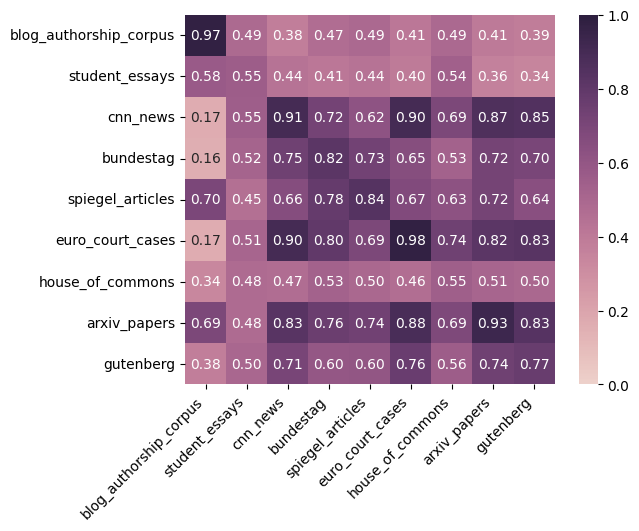

In [92]:
# import matplotlib as mpl
# # Use the pgf backend (must be done before import pyplot interface)
# mpl.use('pgf')

import matplotlib.pyplot as plt

# plt.rcParams.update({
#     "font.family": "serif",  # use serif/main font for text elements
#     "text.usetex": True,     # use inline math for ticks
#     "pgf.rcfonts": False     # don't setup fonts from rc parameters
# })
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(as_cmap=True),
    yticklabels=domains,
    xticklabels=domains,
    square=True,
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

# plt.savefig("../figures/evaluation-trained_in_domain-test_0.1-gpt2-likelihood_256-rand_8.png")
plt.show()

## Cross-Domain Training & Evaluation

In [93]:
from torch.utils.data import ConcatDataset

train_dataloader = PaddingDataloader(
    ConcatDataset(train_datasets.values()),
    feature_dim=config["feature_dim"],
    batch_size=config["batch_size"],
    shuffle=True,
)
eval_dataloader = PaddingDataloader(
    ConcatDataset(eval_datasets.values()),
    feature_dim=config["feature_dim"],
    batch_size=config["batch_size"],
)

seed_everything(config["seed"])
model = DocumentClassficationModel(**config)
trainer = Trainer(
    max_epochs=config["max_epochs"],
    # logger=pl_loggers.TensorBoardLogger(
    #     save_dir="logs/in_domain/",
    #     name=domain,
    # ),
    gradient_clip_val=config["gradient_clip_val"],
    deterministic=True,
    callbacks=[EarlyStopping(monitor="val_roc_auc", mode="max", patience=3)],
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=eval_dataloader,
)

metrics_cross_domain = [
    trainer.test(
        model,
        PaddingDataloader(
            dataset,
            feature_dim=config["feature_dim"],
            batch_size=config["batch_size"],
        ),
    )[0]
    | {"other": other}
    for other, dataset in test_datasets.items()
]

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'conv_layer_shapes' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['conv_layer_shapes'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7992424368858337     │
│         test_loss         │    0.4737263321876526     │
│       test_roc_auc        │    0.9431579113006592     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5400000214576721     │
│         test_loss         │     1.098353624343872     │
│       test_roc_auc        │    0.5420888662338257     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8199999928474426     │
│         test_loss         │    0.4011056125164032     │
│       test_roc_auc        │     0.910444438457489     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.744027316570282     │
│         test_loss         │    0.5561289191246033     │
│       test_roc_auc        │    0.8253635168075562     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7090300917625427     │
│         test_loss         │    0.5825163722038269     │
│       test_roc_auc        │    0.7709172368049622     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9399999976158142     │
│         test_loss         │    0.21783044934272766    │
│       test_roc_auc        │    0.9732000231742859     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.735785961151123     │
│         test_loss         │    0.6383674144744873     │
│       test_roc_auc        │    0.8399999737739563     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8624160885810852     │
│         test_loss         │    0.3534882962703705     │
│       test_roc_auc        │     0.916907012462616     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8257839679718018     │
│         test_loss         │    0.6296774744987488     │
│       test_roc_auc        │    0.8396106958389282     │
└───────────────────────────┴───────────────────────────┘

In [94]:
import pandas as pd

results = []
for domain in domains:
    results.append(
        [results_in_domain[domain]["metrics"][i]["test_roc_auc"] for i in range(len(domains))]
    )
results.append([m["test_roc_auc"] for m in metrics_cross_domain])

df = pd.DataFrame(results, columns=domains, index=domains + ["all"])
df["AVG"] = df.mean(axis=1)
df

,blog_authorship_corpus,student_essays,cnn_news,bundestag,spiegel_articles,euro_court_cases,house_of_commons,arxiv_papers,gutenberg,AVG
blog_authorship_corpus,0.973216,0.487689,0.380089,0.467049,0.492438,0.412933,0.494855,0.405777,0.390365,0.500490
student_essays,0.577251,0.554933,0.435644,0.413497,0.437226,0.396089,0.539732,0.361301,0.344623,0.451144
cnn_news,0.165029,0.553733,0.906178,0.722781,0.618792,0.902222,0.688814,0.865041,0.852871,0.697274
bundestag,0.158684,0.518467,0.745067,0.823080,0.730067,0.649511,0.534787,0.722332,0.703820,0.620646
spiegel_articles,0.696725,0.454867,0.659467,0.777358,0.840134,0.674711,0.626711,0.717939,0.642920,0.676759
euro_court_cases,0.165877,0.514556,0.898533,0.799963,0.693691,0.975600,0.740089,0.820296,0.831071,0.715520
house_of_commons,0.338830,0.482533,0.467467,0.528850,0.497226,0.462444,0.550738,0.512076,0.496399,0.481840
arxiv_papers,0.689357,0.484333,0.828978,0.756432,0.735481,0.883244,0.686622,0.931011,0.832798,0.758695
gutenberg,0.379357,0.501867,0.710444,0.598993,0.602819,0.761956,0.562461,0.738554,0.772214,0.625407
all,0.943158,0.542089,0.910444,0.825364,0.770917,0.973200,0.840000,0.916907,0.839611,0.840188


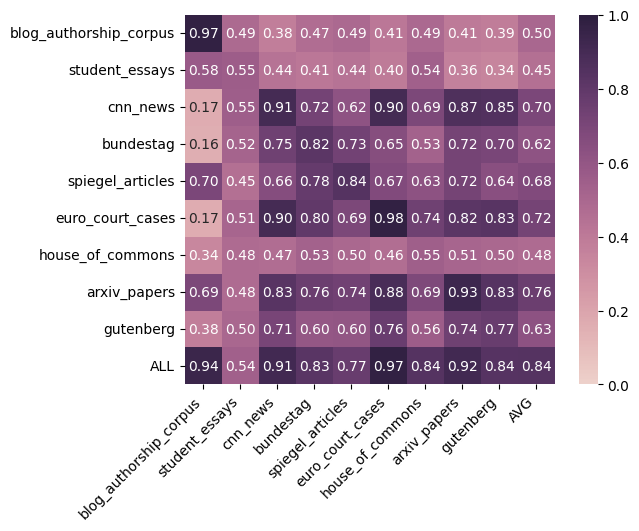

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams.update({
#     "font.family": "serif",  # use serif/main font for text elements
#     "text.usetex": True,     # use inline math for ticks
#     "pgf.rcfonts": False     # don't setup fonts from rc parameters
# })
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(as_cmap=True),
    yticklabels=domains+["ALL"],
    xticklabels=domains+["AVG"],
    square=True,
    # cbar=False
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

# plt.savefig("../figures/evaluation-trained_in_domain-test_0.1-gpt2-likelihood_256-rand_8.png")
plt.show()

In [96]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores

for domain, split in test_splits.items():
    dataset_test = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["type"] != "source"),
            },
            in_place=False,
        )
    )
    fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
    print(domain, auc(fpr, tpr))

blog_authorship_corpus 0.47251461988304094
student_essays 0.8406666666666667
cnn_news 0.9420888888888889
bundestag 0.79805182699478
spiegel_articles 0.8691275167785235
euro_court_cases 0.9043555555555555
house_of_commons 0.7912304250559284
arxiv_papers 0.9532714491708725
gutenberg 0.9035036496350365


In [97]:
raise RuntimeError("STOP")

RuntimeError: STOP

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import luminar.document.model

importlib.reload(luminar.document.model)


from luminar.document.model import ConvolutionalLayerSpec, DocumentClassficationModel

In [ ]:
lr = 0.0001
projection_dim = 0
conv_layer_shapes = (
    [ConvolutionalLayerSpec(64, 5, 1)]
    + [ConvolutionalLayerSpec(128, 3, 1)] * 3
    + [ConvolutionalLayerSpec(64, 3, 1)]
)
model = DocumentClassficationModel(
    feature_size,
    projection_dim=projection_dim,
    conv_layer_shapes=conv_layer_shapes,
    learning_rate=lr,
    warmup_steps=66,
    # second_dim_as_channels=True,
    # feature_activation=torch.nn.Sigmoid(),
)
trainer = Trainer(
    max_epochs=20,
    logger=pl_loggers.TensorBoardLogger(
        save_dir="logs/",
        name=domain,
    ),
    gradient_clip_val=0.5,
    deterministic=True,
    callbacks=[EarlyStopping(monitor="val_roc_auc", mode="max", patience=3)],
)

NameError: name 'feature_size' is not defined

In [ ]:
from itertools import chain

from torch.utils.data import ChainDataset, DataLoader, IterableDataset


class DLI(IterableDataset):
    def __init__(self, dl):
        self.dl = dl

    def __iter__(self):
        yield from self.dl

In [ ]:
trainer.fit(
    model,
    train_dataloaders=DataLoader(ChainDataset(DLI(train.values()))),
    val_dataloaders=DataLoader(ChainDataset(DLI(validation.values()))),
)

In [ ]:
(metrics,) = trainer.validate(model, val_dataloaders=validation.values())
(metrics,) = trainer.test(model, test_dataloaders=test.values())

In [ ]:
# trainer.fit(model, dm)
# (metrics,) = trainer.validate(model, datamodule=dm)
# (metrics,) = trainer.test(model, datamodule=dm)

In [ ]:
# tuner.lr_find(model, datamodule=dm)

In [ ]:
from sklearn.metrics import auc, roc_curve

from luminar.baselines import llr_from_transition_scores

dataset_test = dm._dataset_test.map(
    lambda x: {
        "llr": llr_from_transition_scores(x["features"]),
        "labels": x["labels"],
    },
    in_place=False,
)
fpr, tpr, _ = roc_curve(dataset_test["labels"], dataset_test["llr"])
auc(fpr, tpr)